# An Application to Mango Patchiness Analysis

In [1]:
import matplotlib
%matplotlib nbagg
from matplotlib import pyplot

In [2]:
import os

In [3]:
from statiskit import (linalg,
                       core)

In [4]:
from statiskit.data import core as data
data = data.load('FPD17')

In [5]:
sum_estimator = core.shifted_estimation(core.outcome_type.DISCRETE,
                                        shift = 1,
                                        estimator = core.selection(core.outcome_type.DISCRETE,
                                                                   estimators = [core.poisson_estimation('ml'),
                                                                                 core.binomial_estimation('ml'),
                                                                                 core.negative_binomial_estimation('ml')]))
sum_estimator = core.selection(core.outcome_type.DISCRETE,
                               estimators = [sum_estimator,
                                             core.geometric_estimation('ml'),
                                             core.logarithmic_estimation('ml')])

In [6]:
splitting_estimator = core.splitting_selection('MN', 'DM')

In [7]:
estimator = core.splitting_estimation(sum = sum_estimator,
                                      splitting = splitting_estimator)

In [8]:
import itertools
pi = [1.] * len(data.components)
components = []
for alpha in itertools.product(*([(1.,2.,3.)] * 3)):
    components.append(core.SplittingDistribution(core.PoissonDistribution(1.),
                                         core.MultinomialSplittingOperator(linalg.Vector(alpha))))
initializator = core.MixtureDistribution(*components,
                                         pi = linalg.Vector([1.] * len(components)))
mixest = [core.mixture_estimation(data, 'em',
                                   initializator = initializator,
                                   default_estimator = estimator)]

In [9]:
while len(components) > 2:
    assignment = list(mixest[-1].estimated.assignment(data))
    components.pop(min(set(assignment), key=assignment.count))
    initializator = core.MixtureDistribution(*components,
                                             pi = linalg.Vector([1.] * len(components)))
    mixest.append(core.mixture_estimation(data, 'em',
                                           initializator = initializator,
                                           default_estimator = estimator))

In [10]:
mixest.append(estimator(data, False))
mixest = list(reversed(mixest))

In [11]:
import math
Sm = [result.estimated.loglikelihood(data) for result in mixest]
Dm = [mixest[0].estimated.nb_parameters] + [result.estimated.nb_parameters for result in mixest[1:]]
BICm = [s - d * math.log(data.total) / 2 for s, d in zip(Sm, Dm)]
Cm = [1] + [result.estimated.nb_states for result in mixest[1:]]
Um = [0] + [result.estimated.uncertainty(data) for result in mixest[1:]]
ICLm = [bic - u for (bic, u) in zip(BICm, Um)]

<IPython.core.display.Javascript object>


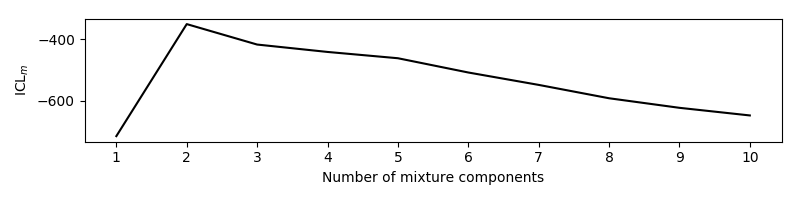

In [12]:
limit = 10
fig = pyplot.figure(figsize=(8,2))
axes = fig.add_subplot(111)
axes.plot(Cm[:limit], ICLm[:limit], color='k')
axes.set_xticks(range(1, limit + 1))
axes.set_xlabel('Number of mixture components')
axes.set_ylabel('ICL$_m$')
pyplot.tight_layout()
try:
    fig.savefig('selection.pgf')
except:
    pass
fig.savefig('selection.svg')

In [13]:
mixest[1].estimated.pi

[0.439130371172]
[0.560869628828]

In [14]:
mixest[1].estimated.observations[0]

M(S, [   0.209987156258]
[4.50113969414e-05]
[   0.789967832345]) /\ NB(0.163165541748, 0.762433409996, 1)

In [15]:
mixest[1].estimated.observations[1]

M(S, [0.543747150748]
[0.174948830374]
[0.281304018878]) /\ NB(3.96359565455, 0.400715716389, 1)

<IPython.core.display.Javascript object>


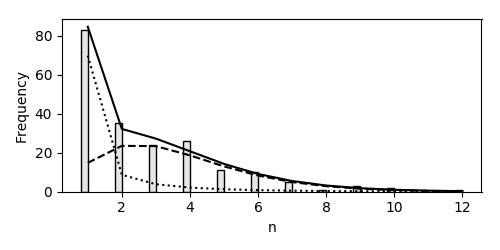

In [16]:
sum_data = core.from_list([sum([event.value for event in events]) for events in data.events])
dist = mixest[1].estimated
fig = pyplot.figure(figsize=(5,2.5))
sum_dist = core.MixtureDistribution(dist.observations[0].sum,
                                    dist.observations[1].sum,
                                    pi = dist.pi)
axes = sum_dist.pdf_plot(axes = fig.add_subplot(111),
                         color = 'k',
                         fmt = '-',
                         norm = sum_data.total,
                         qmin = sum_data.min.value,
                         qmax = sum_data.max.value,
                         states = [dict(fmt = ':'),
                                   dict(fmt = '--')])
axes = sum_data.pdf_plot(axes = axes, color='#e6e6e6',
                                      edgecolor='k')
axes.set_xlabel('n')
axes.set_ylabel('Frequency')
pyplot.tight_layout()
try:
    fig.savefig('sum.pgf')
except:
    pass
fig.savefig('sum.svg')

In [17]:
pi = [1.] * len(data.components)
components = []
for alpha in itertools.product(*([(1.,2.,3.)] * 3)):
    components.append(core.MultinomialSplittingOperator(linalg.Vector(alpha)))
initializator = core.SplittingMixtureOperator(components,
                                              linalg.Vector([1.] * len(components)))
splest = [core.splitting_estimation(data,
                                    sum = sum_estimator,
                                    splitting = core.splitting_mixture_estimation(initializator = initializator,
                                                                                  default_estimator = splitting_estimator))]

In [18]:
while len(components) > 2:
    assignment = list(splest[-1].splitting.estimated.assignment(data))
    components.pop(min(set(assignment), key=assignment.count))
    initializator = core.SplittingMixtureOperator(components,
                                                  linalg.Vector([1.] * len(components)))
    splest.append(core.splitting_estimation(data,
                                            sum = sum_estimator,
                                            splitting = core.splitting_mixture_estimation(initializator = initializator,
                                                                                          default_estimator = splitting_estimator)))

In [19]:
splest.append(mixest[0])
splest = list(reversed(splest))

In [20]:
Ss = [result.estimated.loglikelihood(data) for result in splest]
Ds = [splest[0].estimated.nb_parameters] + [result.estimated.nb_parameters for result in splest[1:]]
BICs = [s - d * math.log(data.total) / 2 for s, d in zip(Ss, Ds)]
Cs = [1] + [result.splitting.estimated.nb_states for result in splest[1:]]
Us = [0] + [result.splitting.estimated.uncertainty(data) for result in splest[1:]]
ICLs = [bic - u for (bic, u) in zip(BICs, Us)]

<IPython.core.display.Javascript object>


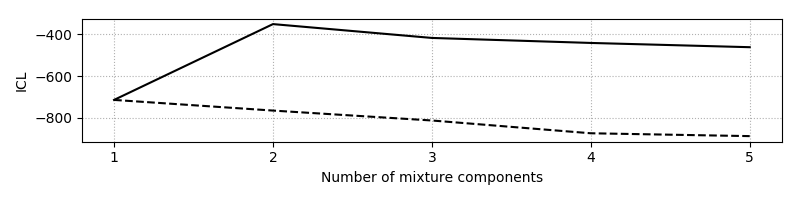

In [21]:
limit = 5
fig = pyplot.figure(figsize=(8,2))
axes = fig.add_subplot(111)
axes.xaxis.grid('on', linestyle=':')
axes.yaxis.grid('on', linestyle=':')
axes.plot(Cm[:limit], ICLm[:limit], color='k')
axes.set_xticks(range(1, limit + 1))
axes.set_xlabel('Number of mixture components')
axes.set_ylabel('ICL')
# axes = axes.twinx()
# axes.set_frame_on(False)
axes.plot(Cs[:limit], ICLs[:limit], color='k', linestyle='--')
# axes.set_ylabel('ICL$_s$')
pyplot.tight_layout()
try:
    fig.savefig('selection.pgf')
except:
    pass
fig.savefig('selection.svg')

In [22]:
splest[0].estimated

DM(S, [  3.0677052851]
[0.867962462832]
[ 2.98830062598]) /\ G(0.631868131868)